In [1]:
import os
cmd = 'pip list'
res = os.popen(cmd)
output_str = res.read()
print(output_str)

Package                            Version
---------------------------------- -------------------
absl-py                            0.11.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
applaunchservices                  0.2.1
appnope                            0.1.0
appscript                          1.1.1
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autobahn                           20.12.3
Automat                            20.2.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                         

In [2]:
#!/usr/bin/env python3
import sys
sys.path.insert(0, "../src/")
import torch
from data.graph_transformer import *
from data.prepare_dataset import *
from plotter.plot_graph import *
from model.gnn import *
from model.train_model import *
from output.predict_model import *
import os
os.chdir("../")
import pbzlib
import networkx as nx

## Deep FP: training example

### Data Understanding



The data given is of the type of serializable protobuf messages. The author of the paper gives an example of script to read the data. 
The data is stored in hierarichal manner: 
- **Network object:** a description of the network, contains servers objects, flows objects
- **Server object:** a description of a server in the network, contains its parameters: id, rate and latency
- **Flow object:** a description of a flow in the network, contains its parameter: id, rate, burst, path and FPResult object
- **FPResult object:** contains the results of different explored combinations. It contains a FPCombination object for each combination
- **FPCombination object:** contains the delay bound achieved and the prolongations

For a better understanding, a proto file is added in the data folder

### Data preparation

The package src.data contains our data preparation modules. 

We do data preparation in two steps, namely (1) creating a networkx graph each given network and then (2) converting the graph object to a torch tensor to feed it to the network. The data preparation is an implementation of Algorithm 1 in the paper.

The first part of the algorithm creates a base graph i.e a graph without prolongation nodes.
This was done in graph_transformer module.


In [3]:
# the first network of the dataset
# network = next(pbzlib.open_pbz("data/raw/dataserv.ub.tum.de/dataset-evaluation.pbz"))
network = next(pbzlib.open_pbz("/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/data/raw/dataserv.ub.tum.de/dataset-train.pbz"))
G, flows_paths = net2basegraph(network)

In [4]:
print(network)

server {
  rate: 0.652298881523439
  latency: 0.5384246880613892
}
server {
  id: 1
  rate: 0.1981014874337499
  latency: 0.14038693814170045
}
server {
  id: 2
  rate: 0.5586898242041254
  latency: 0.4173048057735682
}
server {
  id: 3
  rate: 0.6704675095373693
  latency: 0.027387597179620027
}
server {
  id: 4
  rate: 0.8781174306508484
  latency: 0.20445225303549885
}
server {
  id: 5
  rate: 0.6852195043049478
  latency: 0.4191945092867837
}
server {
  id: 6
  rate: 0.9168613286559002
  latency: 0.0836230021541644
}
server {
  id: 7
  rate: 0.49305959663062193
  latency: 0.9499381437063239
}
flow {
  rate: 0.00031810534748519687
  burst: 0.968261581700407
  path: 5
  path: 4
  path: 3
  path: 2
  path: 1
  pmoo {
    delay_bound: 41.661718156913125
  }
  pmoofp {
    delay_bound: 41.661718156913125
    explored_combination {
      delay_bound: 41.70474947639015
      flows_prolongation {
        key: 2
        value: 1
      }
    }
    explored_combination {
      delay_bound: 41

Graph with 25 nodes and 61 edges


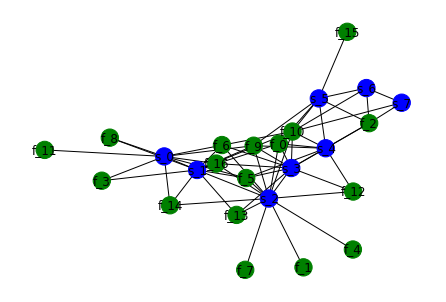

In [5]:
plot_graph_network(G)
print(G)

Now the graph created needs to be augmented to have the prolongation nodes. This is part 2 of Algorithm 1.

In [6]:
# We prolong the graph using the flow of interest 1
G, _, node_ids = prolong_graph(G, 9, flows_paths)
# the reason why the index is out of range is because that flow is not the flow of interest

Graph with 53 nodes and 117 edges


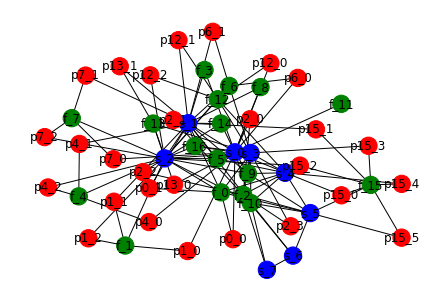

In [7]:
# visualizing the new graph
plot_graph_network(G)
print(G)

After creating a networkx graph from the network, we need to transform it to something that can be fed to a neural network. We convert it a torch tensor. This is done in prepare_dataset module, namely the method below

In [8]:
graph2torch(G, node_ids)

Data(x=[53, 10], edge_index=[2, 234], y=[53], mask=[53])

In [18]:
prepare_dataset("/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/data/raw/dataserv.ub.tum.de/dataset-train.pbz", train= True, to_pickle= True )
prepare_dataset("/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/data/raw/dataserv.ub.tum.de/dataset-evaluation.pbz", train= False, to_pickle= True )

([Data(x=[27, 10], edge_index=[2, 116], y=[27], mask=[27]),
  Data(x=[36, 10], edge_index=[2, 152], y=[36], mask=[36]),
  Data(x=[81, 10], edge_index=[2, 350], y=[81], mask=[81]),
  Data(x=[54, 10], edge_index=[2, 242], y=[54], mask=[54]),
  Data(x=[80, 10], edge_index=[2, 386], y=[80], mask=[80]),
  Data(x=[48, 10], edge_index=[2, 258], y=[48], mask=[48]),
  Data(x=[59, 10], edge_index=[2, 302], y=[59], mask=[59]),
  Data(x=[61, 10], edge_index=[2, 310], y=[61], mask=[61]),
  Data(x=[73, 10], edge_index=[2, 358], y=[73], mask=[73]),
  Data(x=[59, 10], edge_index=[2, 302], y=[59], mask=[59]),
  Data(x=[46, 10], edge_index=[2, 250], y=[46], mask=[46]),
  Data(x=[96, 10], edge_index=[2, 450], y=[96], mask=[96]),
  Data(x=[35, 10], edge_index=[2, 206], y=[35], mask=[35]),
  Data(x=[48, 10], edge_index=[2, 258], y=[48], mask=[48]),
  Data(x=[73, 10], edge_index=[2, 358], y=[73], mask=[73]),
  Data(x=[44, 10], edge_index=[2, 222], y=[44], mask=[44]),
  Data(x=[29, 10], edge_index=[2, 162], 

Preparing the dataset is doing all the steps on all the networks and flows of interest in the dataset.

### The model

The model is described in the paper. It can be used like follows.


In [9]:
model = GGNN(9, 96, unrolls= 2)

You can train the model using the method train_model, it takes the path of the data pickle objects

In [10]:
train_graphs_path = "/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/data/processed_serialized/train_graphs.pickle"
train_targets_path = "/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/data/processed_serialized/train_targets.pickle"
test_graphs_path = "/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/data/processed_serialized/test_graphs.pickle"
test_targets_path = "/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/data/processed_serialized/test_targets.pickle"

# you can train the model using train_model method
train_model(model= model, train_graphs= train_graphs_path, train_targets= train_targets_path,\
           test_graphs= test_graphs_path, test_targets= test_targets_path, learning_rate= 0.05, epochs= 30 )

  3%|▎         | 1/30 [26:35<12:51:21, 1595.90s/it]

  0 | loss=8.81e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05688073394495413


  7%|▋         | 2/30 [53:18<12:26:40, 1600.03s/it]

  1 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.055137614678899084


 10%|█         | 3/30 [1:19:46<11:57:28, 1594.38s/it]

  2 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05623853211009174


 13%|█▎        | 4/30 [1:44:59<11:16:58, 1562.27s/it]

  3 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.055504587155963306


 17%|█▋        | 5/30 [5:04:04<36:50:54, 5306.18s/it]

  4 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05853211009174312


 20%|██        | 6/30 [6:36:20<35:53:49, 5384.55s/it]

  5 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.056605504587155964


 23%|██▎       | 7/30 [7:03:08<26:30:45, 4149.81s/it]

  6 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05798165137614679


 27%|██▋       | 8/30 [7:35:43<21:05:21, 3450.99s/it]

  7 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05678899082568807


 30%|███       | 9/30 [9:26:12<25:55:38, 4444.68s/it]

  8 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05577981651376147


 33%|███▎      | 10/30 [12:13:25<34:16:33, 6169.69s/it]

  9 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05761467889908257


 37%|███▋      | 11/30 [17:15:43<51:53:41, 9832.69s/it]

 10 | loss=8.80e-01  | test_accuracy_deepfp= 0.006513761467889908 | test_accuracy_deepfp4= 0.05238532110091743


 40%|████      | 12/30 [17:59:44<38:13:28, 7644.91s/it]

 11 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05688073394495413


 43%|████▎     | 13/30 [18:27:25<27:32:28, 5832.25s/it]

 12 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.055504587155963306


 47%|████▋     | 14/30 [18:53:03<20:09:23, 4535.22s/it]

 13 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.055504587155963306


 50%|█████     | 15/30 [19:18:45<15:08:13, 3632.87s/it]

 14 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05504587155963303


 53%|█████▎    | 16/30 [19:44:21<11:40:25, 3001.83s/it]

 15 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05706422018348624


 57%|█████▋    | 17/30 [20:09:24<9:12:43, 2551.04s/it] 

 16 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05706422018348624


 60%|██████    | 18/30 [21:47:08<11:49:17, 3546.47s/it]

 17 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05412844036697248


 63%|██████▎   | 19/30 [22:44:31<10:44:29, 3515.40s/it]

 18 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.056605504587155964


 67%|██████▋   | 20/30 [23:11:01<8:09:34, 2937.44s/it] 

 19 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05926605504587156


 70%|███████   | 21/30 [23:37:59<6:21:13, 2541.46s/it]

 20 | loss=8.80e-01  | test_accuracy_deepfp= 0.006513761467889908 | test_accuracy_deepfp4= 0.058440366972477065


 73%|███████▎  | 22/30 [24:07:43<5:08:33, 2314.16s/it]

 21 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05587155963302752


 77%|███████▋  | 23/30 [24:36:33<4:09:30, 2138.64s/it]

 22 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05321100917431193


 80%|████████  | 24/30 [25:02:08<3:15:45, 1957.58s/it]

 23 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05770642201834862


 83%|████████▎ | 25/30 [25:27:30<2:32:15, 1827.01s/it]

 24 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05559633027522936


 87%|████████▋ | 26/30 [25:53:45<1:56:44, 1751.15s/it]

 25 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05412844036697248


 90%|█████████ | 27/30 [26:19:52<1:24:47, 1695.97s/it]

 26 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05678899082568807


 93%|█████████▎| 28/30 [26:46:05<55:18, 1659.28s/it]  

 27 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.055504587155963306


 97%|█████████▋| 29/30 [27:12:10<27:10, 1630.81s/it]

 28 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.05761467889908257


100%|██████████| 30/30 [27:36:19<00:00, 3312.64s/it]


 29 | loss=8.80e-01  | test_accuracy_deepfp= 0.0 | test_accuracy_deepfp4= 0.057247706422018346


(GGNN(
   (init_layer): Sequential(
     (0): Linear(in_features=9, out_features=96, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
   )
   (gru): GatedGraphConv(96, num_layers=1)
   (edge_attention): Sequential(
     (0): Linear(in_features=192, out_features=96, bias=True)
     (1): Sigmoid()
     (2): Linear(in_features=96, out_features=1, bias=True)
     (3): Sigmoid()
   )
   (out): Sequential(
     (0): Linear(in_features=96, out_features=96, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=96, out_features=96, bias=True)
     (3): LeakyReLU(negative_slope=0.01)
   )
   (out1): Sequential(
     (0): Linear(in_features=96, out_features=1, bias=True)
     (1): Sigmoid()
   )
   (out2): Sequential(
     (0): Linear(in_features=96, out_features=1, bias=True)
     (1): Sigmoid()
   )
 ),
 [0.8808427068959336,
  0.8797310639635847,
  0.8799017580265694,
  0.8798981539457313,
  0.8797471680261609,
  0.8797991225026623,
  0.8797298228631673,
  0.879763

### Using the model for predicting new network

You can use the model to predict flow prolongations for a new network using predict_model module in the output package

In [13]:
print(os.getcwd())
os.chdir("src/output/")
print(os.getcwd())
graph = predict_network(network= network, foi_id=0, model= model)
print(graph)

/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main
/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/src/output
Data(x=[41, 10], edge_index=[2, 186], y=[41], mask=[41])


flows_path :  {0: [5, 4, 3, 2, 1], 1: [2], 2: [7, 6, 5, 4, 3], 3: [1, 0], 4: [2], 5: [4, 3, 2, 1, 0], 6: [3, 2, 1], 7: [2], 8: [1, 0], 9: [5, 4, 3, 2, 1, 0], 10: [7, 6, 5, 4, 3, 2, 1, 0], 11: [0], 12: [4, 3, 2], 13: [3, 2, 1], 14: [2, 1, 0], 15: [5], 16: [3, 2, 1, 0]}
G_f :  Graph with 41 nodes and 93 edges
pro_dict:  defaultdict(<class 'list'>, {1: ['p1_2', 'p1_1'], 2: ['p2_3', 'p2_2', 'p2_1'], 4: ['p4_2', 'p4_1'], 7: ['p7_2', 'p7_1'], 12: ['p12_2', 'p12_1'], 15: ['p15_5', 'p15_4', 'p15_3', 'p15_2', 'p15_1']})
node_ids:  {'s_0': 0, 's_1': 1, 's_2': 2, 's_3': 3, 's_4': 4, 's_5': 5, 's_6': 6, 's_7': 7, 'f_0': 8, 'f_1': 9, 'f_2': 10, 'f_3': 11, 'f_4': 12, 'f_5': 13, 'f_6': 14, 'f_7': 15, 'f_8': 16, 'f_9': 17, 'f_10': 18, 'f_11': 19, 'f_12': 20, 'f_13': 21, 'f_14': 22, 'f_15': 23, 'f_16': 24, 'p1_2': 25, 'p1_1': 26, 'p2_3': 27, 'p2_2': 28, 'p2_1': 29, 'p4_2': 30, 'p4_1': 31, 'p7_2': 32, 'p7_1': 33, 'p12_2': 34, 'p12_1': 35, 'p15_5': 36, 'p15_4': 37, 'p15_3': 38, 'p15_2': 39, 'p15_1': 40}


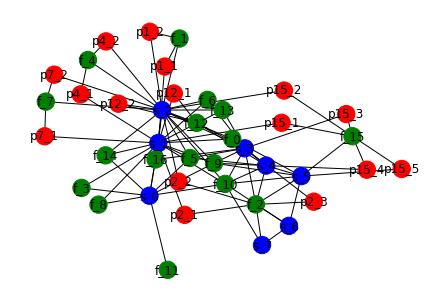

In [49]:
# prolong the graph with respect to the foi
G_f, pro_dict, node_ids = prolong_graph(G, 0, flows_path)
print("flows_path : ", flows_path)
print("G_f : ", G_f)
print("pro_dict: ", pro_dict)
print("node_ids: ", node_ids)
plot_graph_network(G_f)
graph = predict_network(network, 5, model, output_file="output.pbz")
print("graph : ", graph)

In [73]:
import re
for dest in pro_dict:
    # print(pro_dict.keys())
    print(re.match('.*?([0-9]+)$', pro_dict[dest][-1]).group(1))

1
1
1
1
1
1


IndexError: list index out of range

# That's all !


if you have any questions, you can contact me on karim.hadidane@epfl.ch